# MA 346 Final Project: Predicting Avocado Prices

By Zachary Chin

This is the exploration file for creating a model that is capable of predicting future prices of avocados, with slicers for location, type, and season.

To begin we import some modules to manipulate the data and build models.

In [1]:
# importing modules to work with avocado data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import streamlit as st
# for fitting to a curve
from scipy.optimize import curve_fit

No errors, so the modules were imported without problems.

In the next block we import the data that we are using (`avocado.csv`) and edit a few of the columns to fit our needs. The `Date` column is set to be datetime and the unnamed column is renamed to `Week`. Another column is also going to be added to refer to the season of the observation. Then it is sorted ascending by date. Finally it is split into two different dataframes for the two different types of avocado. This is the first part of the filtering.

In [2]:
# importing the data set
avo = pd.read_csv("avocado.csv")

# converting date to datetime and renaming the first column
avo["Date"] = pd.to_datetime(avo["Date"])
avo = avo.rename(columns={"Unnamed: 0": "Week"})

# add season column using datetime
season_dict = {1:"Winter",2:"Winter",3:"Spring",4:"Spring",5:"Spring",6:"Summer",
               7:"Summer",8:"Summer",9:"Fall",10:"Fall",11:"Fall",12:"Winter"}
avo["Season"] = avo["Date"].dt.month.map(season_dict)

# Splitting into organic and conventional type avocodos and indexing by date
def index_by_date(df):
    df = df.sort_values("Date", ascending=True)
    df.index = df["Date"]
    return df

# splitting
avoOrg = avo[avo["type"]=="organic"]
avoOrg = index_by_date(avoOrg)
avoCon = avo[avo["type"]=="conventional"]
avoCon = index_by_date(avoCon)
avoCon[avoCon["region"]=="LasVegas"]
avoCon

,Week,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Season
Date,,,,,,,,,,,,,,,
2015-01-04,51,2015-01-04,0.93,5777334.90,2843648.26,2267755.26,137479.64,528451.74,477193.38,47882.56,3375.80,conventional,2015,California,Winter
2015-01-04,51,2015-01-04,1.10,407675.56,24190.91,294715.33,2121.45,86647.87,72829.94,13817.93,0.00,conventional,2015,Philadelphia,Winter
2015-01-04,51,2015-01-04,0.98,3204112.16,2296069.27,320373.63,18938.42,568730.84,287820.14,280910.70,0.00,conventional,2015,Southeast,Winter
2015-01-04,51,2015-01-04,1.40,116253.44,3267.97,55693.04,109.55,57182.88,57182.88,0.00,0.00,conventional,2015,BuffaloRochester,Winter
2015-01-04,51,2015-01-04,0.80,317861.35,134003.07,120628.37,4591.23,58638.68,58126.59,512.09,0.00,conventional,2015,LasVegas,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-25,0,2018-03-25,0.95,306280.52,125788.54,10713.80,334.61,169443.57,136737.44,30406.07,2300.06,conventional,2018,Nashville,Spring
2018-03-25,0,2018-03-25,1.04,305105.53,171335.77,20076.04,2425.10,111268.62,94895.33,15963.29,410.00,conventional,2018,NewOrleansMobile,Spring
2018-03-25,0,2018-03-25,1.23,986038.75,108250.52,591934.75,4205.03,281648.45,277508.08,2777.04,1363.33,conventional,2018,BaltimoreWashington,Spring


The output dataframe has all "conventional" type avocados, meaning that the slicing was successful. Other than that no errors are outputted. It also is now sorted ascending by date. It can now be easier used for creating a model.

The next code block will create the first model of predictions as a function so that it can take inputs and output the model that can be used. This uses the `curve_fit` function to fit the data to the found model of ε * SIN(α + β * t) + γ * t + ρ. It will also output the SSE of the model to see how well it fits the data. It also defines the values for region, season, and type for the avocado data that will be used for the rest of the exploration.

In [3]:
# function to fit line to certain inputs
testRegion = "LasVegas"
testSeason = "Spring"
testType = "Organic"

# ε * sin(α + β * t) + γt + ρ
# this curve with several variables fits them to manipulate a sin curve to fit the data
# ε for amplitude, α for shift left/right, β for frequency, γ for slope, ρ is intercept
def sin_curve (t, α, β, γ, ε, ρ):
    return ε * (np.sin((α + β * t))) + (γ * t) + ρ

def fit_test_to_curve(region, avotype):
    """
    creates a dataframe from several filters and then uses that dataframe to predict the price of an avocado given the certain filters
    """
    # setting it as the conventional series or an organic series
    if avotype == "Conventional":
        series = pd.Series(avoCon.loc[avoCon["region"]==region, "AveragePrice"])
        series.index = pd.Series(avoCon.loc[avoCon["region"]==region, "Date"])
    else:
        series = pd.Series(avoOrg.loc[avoOrg["region"]==region, "AveragePrice"])
        series.index = pd.Series(avoOrg.loc[avoOrg["region"]==region, "Date"])

    dateseries = series.index

    # fitting the data to the curve
    # resetting index to make it work with curve_fit
    series = series.reset_index(drop=True).dropna()

    # setting x as the date, and ys as the average price
    xs = series.index
    ys = series

    # using the curve_fit function to get betas
    beta_guess = [0, 0.1, -1, 0.5, 1.5]
    found_params, covariance = curve_fit(sin_curve, xs,ys,p0=beta_guess, maxfev=2000)
    α, β, γ, ε, ρ = found_params

    # find SSE
    fit_model = lambda x: sin_curve(x, α, β, γ, ε, ρ)
    SSE = np.sum((fit_model(series.index)-series)**2)

    # returning betas
    return fit_model, SSE, series
    
predicted, curveSSE, series = fit_test_to_curve(testRegion, testType)


It returns the outputs without any errors, and the accuracy of the model will be determined in the next few code blocks.

This next block plots the model created by the previous function against the actual values that the model is trying to predict. 

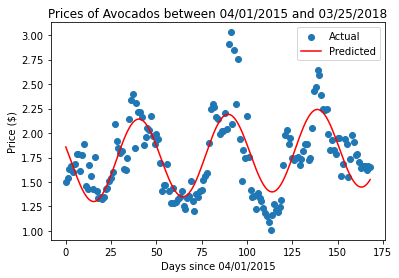

In [4]:
plt.title(f"Prices of Avocados between 04/01/2015 and 03/25/2018")
plt.xlabel(f"Days since 04/01/2015")
plt.ylabel("Price ($)")
plt.scatter(series.index, series)
plt.plot(series.index, predicted(series.index), c="red")
plt.legend(labels=["Actual", "Predicted"])

From this plot we can see that the model is a fairly good fit, and the previous function has worked correctly.

Next we see the models future prediction ability by predicting a value that correlates with spring of 2019, a year in the future relative to the data used.

In [5]:
predicted(170+52)

1.7696830056668857

This value appears to be reasonable, so everything worked as expected.

Next we fit a second model to the data. This model is the ARIMA seasonal model and is done mostly using the statsmodels module. This will be used alongside the previous model to try to create better predictions. Just like the last model it outputs the SSE so that the models can be compared.

In [6]:
## Using Seasonal ARIMA model
# https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# time series to use
def fit_to_timeseries(region, avotype):
    # fits a time-series ARIMA model to selected data
    timeseries = pd.DataFrame()
    # setting it as the conventional series or an organic series
    if avotype == "Conventional":
        timeseries["AveragePrice"] = pd.Series(avoCon.loc[avoCon["region"]==region, "AveragePrice"])
        timeseries.index = pd.Series(avoCon.loc[avoCon["region"]==region, "Date"])
    else:
        timeseries["AveragePrice"] = pd.Series(avoOrg.loc[avoOrg["region"]==region, "AveragePrice"])
        timeseries.index = pd.Series(avoOrg.loc[avoOrg["region"]==region, "Date"])

    # fitting to a model
    mod = sm.tsa.statespace.SARIMAX(timeseries["AveragePrice"], trend='n', order=(0,0,1), seasonal_order=(0,1,1,52))
    results = mod.fit()

    # series of the predicted values
    timeseries["forecast"] = results.predict(start=53, end=169)

    # finding the SSE of the model
    timeseries = timeseries.reset_index(drop=True).dropna()
    SSE = np.sum((timeseries.loc[53:, "forecast"] - timeseries.loc[53:, "AveragePrice"])**2)

    # returning predicted values and SSE
    return results, timeseries["forecast"], SSE
    
results, forecast, timeSSE = fit_to_timeseries(testRegion, testType)

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


These warnings are mostly due to the limitations of trying to make the function general and work for all the different slices that it goes through. Other than that, there are no errors so we can assume it worked correctly.

Below the predictions are graphed to see how well the model works. There is also some editing done to the predictions to get it to be plotted as intended.

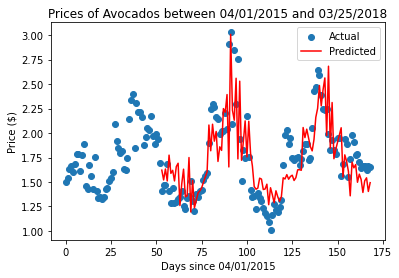

In [7]:
# editing the forecast series so that it is the same length as the actual values
precedingNulls = pd.Series([np.nan]*53)
forecast = precedingNulls.append(forecast)
# plotting
plt.title(f"Prices of Avocados between 04/01/2015 and 03/25/2018")
plt.xlabel(f"Days since 04/01/2015")
plt.ylabel("Price ($)")
plt.scatter(series.index, series)
plt.plot(series.index, forecast, c="red")
plt.legend(labels=["Actual", "Predicted"])

The graph looks very well fit to the data, so our model is successful. It is also able to create similar models for other slices, but is not as versatile as the previous model.

Below the prediction ability of this model is demonstrated by using the `.predict` function available from the model.

In [8]:
results.predict(170+52)[0]

1.3399963131983368

This appears to be a reasonable value to expect for the prediction in Spring of 2019, and is relatively similar to the value predicted by the other model.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a9287e1c-6bc1-4264-baea-d2d6d56ccf53' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>